# Detection of light-coloured sheet metal parts on a light-coloured background

This example demonstrates how to use NxLib and OpenCV to detect light-coloured sheet metal parts on a light-coloured background. We learn how to open a camera using NxLib, capture a depth image and create a 2.5D projection of the data. The detection of the metal parts is done by thresholding the height-data from the projection and thus is independent of ambient light.

![Image of light-coloured metal parts to be detected.](./detect_sheet_metal.jpg "Parts on light-coloured background.")

## Key Learnings
- Basic camera handling and capture
- Usage of a calibration pattern for setting up a practical workspace coordinate system
- Usage of the 2.5D projections from *RenderPointMap*

## Preparations
- Before capturing an image, the workspace of the camera needs to be set up. The perspective of the camera is corrected by setting up the workspace coordinate system to be on the ground below the metal parts.
- After mounting the camera, first a workspace calibration will be performed. This is done by placing a calibration pattern on the work surface and then using the function *Workspace Calibration* from **NxView**.
- In the next step, the origin of the coordinate system is set to the work surface. This is again done by placing the calibration pattern on it and then using the function *Set origin with calibration plate* from **NxView**. This ensures that the x- and y-axes are parallel to the ground and the work surface is zeroed in z-direction.

For this example we provide a suitable file camera here: [detect_sheet_metal.enscam](detect_sheet_metal.enscam). Add the file camera to **NxView** by clicking on *Create ... -> File Camera* on the main screen of **NxView**.

## Python environment

This example expects a Python environment of version 3.10 or higher. The following packages will be used:
- NxLib (`nxlib`)
- Numpy (`numpy`)
- OpenCV (`cv2`)

The example was tested with NxLib version 4.1.1033.

In [1]:
import nxlib
from nxlib import constants as nxc

import numpy as np
import cv2

import matplotlib.pyplot as plt

## Capture

Open camera via NxLib and capture a measurement.

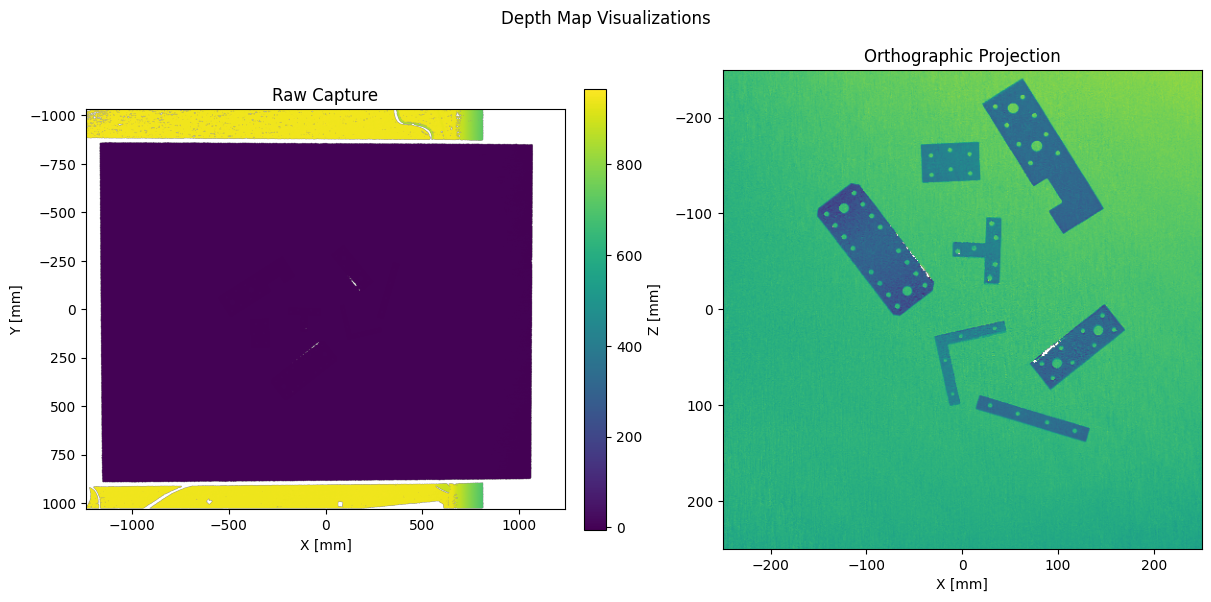

In [2]:
CAM_SERIAL = "detect_sheet_metal"
IMG_SIZE = [500, 500]
PIXEL_SIZE_MM = 1

# Open NxLib and a camera using the same context
with nxlib.NxLib(), nxlib.Camera.from_serial(CAM_SERIAL, [nxc.VAL_STRUCTURED_LIGHT, nxc.VAL_STEREO]) as cam:

    camera_node = cam.get_node()
    camera_node["Parameters"]["SurfaceConnectivity"].set_double(20)

    # Capture image
    cam.capture()
    cam.rectify()
    cam.compute_disparity_map()
    cam.compute_point_map()
    regular_point_map = cam.get_point_map()

    # Run RenderPointMap command to calculate the rectified/projected point map
    params = {
        "PixelSize": PIXEL_SIZE_MM,
        "Size": IMG_SIZE,
        "ViewPose": {
            "Rotation": {
                "Angle": 0,
                "Axis": [0, 0, 0]
            },
            "Translation": [0, 0, 0]
        }
    }

    with nxlib.NxLibCommand(nxc.CMD_RENDER_POINT_MAP, params=params) as cmd:
        cmd.execute()
        projected_point_map = cmd.result()["Images"]["RenderPointMap"].get_binary_data()
        projected_texture = cmd.result()["Images"]["RenderPointMapTexture"].get_binary_data()[:, :, :3]
        projected_texture = np.ascontiguousarray(projected_texture)

# Image dimensions
H1, W1 = regular_point_map.shape[:2]
H2, W2 = projected_point_map.shape[:2]

# Coordinate axes in mm
x1 = np.linspace(-W1 / 2 * PIXEL_SIZE_MM, W1 / 2 * PIXEL_SIZE_MM, W1)
y1 = np.linspace(-H1 / 2 * PIXEL_SIZE_MM, H1 / 2 * PIXEL_SIZE_MM, H1)
x2 = np.linspace(-W2 / 2 * PIXEL_SIZE_MM, W2 / 2 * PIXEL_SIZE_MM, W2)
y2 = np.linspace(-H2 / 2 * PIXEL_SIZE_MM, H2 / 2 * PIXEL_SIZE_MM, H2)

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
fig.suptitle("Depth Map Visualizations")

# Plot left: Raw Capture
im1 = ax1.imshow(regular_point_map[:, :, 2], extent=[x1[0], x1[-1], y1[-1], y1[0]], cmap='viridis')
ax1.set_title("Raw Capture")
ax1.set_xlabel("X [mm]")
ax1.set_ylabel("Y [mm]")
ax1.set_aspect('equal')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('Z [mm]')

# Plot right: Orthographic Projection
im2 = ax2.imshow(projected_point_map[:, :, 2], extent=[x2[0], x2[-1], y2[-1], y2[0]], cmap='viridis')
ax2.set_title("Orthographic Projection")
ax2.set_xlabel("X [mm]")
ax2.set_aspect('equal')

plt.show()

## Image Postprocessing

First, the depth information is converted into a height map, where each pixel represents the height of a surface point above a reference plane. To isolate the sheet metal pieces, we apply two thresholds to select points close to the reference plane. In the next step, thresholding is applied to exclude distant points and the resulting binary mask is plotted.

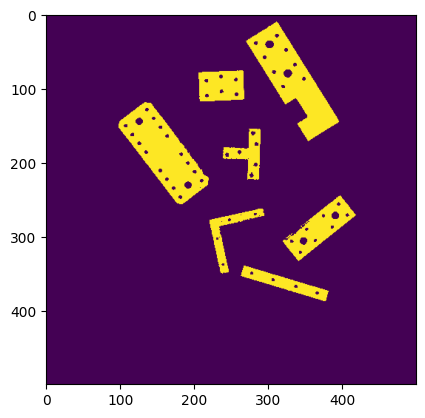

In [3]:
# Create height image
height_image = projected_point_map[:, :, 2]
height_image[np.isnan(height_image)] = -100

# Filter out points with distance > -0.5 mm (in +Z direction) and < -3.5 mm (in -Z direction) from reference plane
height_image[(height_image > -0.5)] = -100
height_image[(height_image < -3.5)] = -100

# Binarize height image
_, height_mask = cv2.threshold(height_image, -3.5, 255, cv2.THRESH_BINARY)
height_mask = np.asarray(height_mask, dtype = np.uint8)

# Plot binary mask
plt.imshow(height_mask)

## Contour detection

In this step the contours of the objects in the binarized height image are computed. For each contour the minimum bounding rectangle is calculated. If the corresponding area of the rectangle is bigger than zero, it is highlighted in the texture image.

In [4]:
# Detect contours of all objects in height image
contours, _ = cv2.findContours(height_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
texture = projected_texture.copy()

for i, c in enumerate(contours):
    # Compute minimum bounding rectangle and its area
    center, size, angle = cv2.minAreaRect(c)
    area = size[0] * size[1]
    
    # Highlight rectangle if area is > 300
    if area > 300:
        rect = (center, size, angle)
        box = np.intp(cv2.boxPoints (rect))
        cv2.drawContours(projected_texture, [box], 0, (0, 255, 0), 2)
        cv2.drawContours(projected_texture, contours, i, color = (255, 0, 255), thickness = 1)     

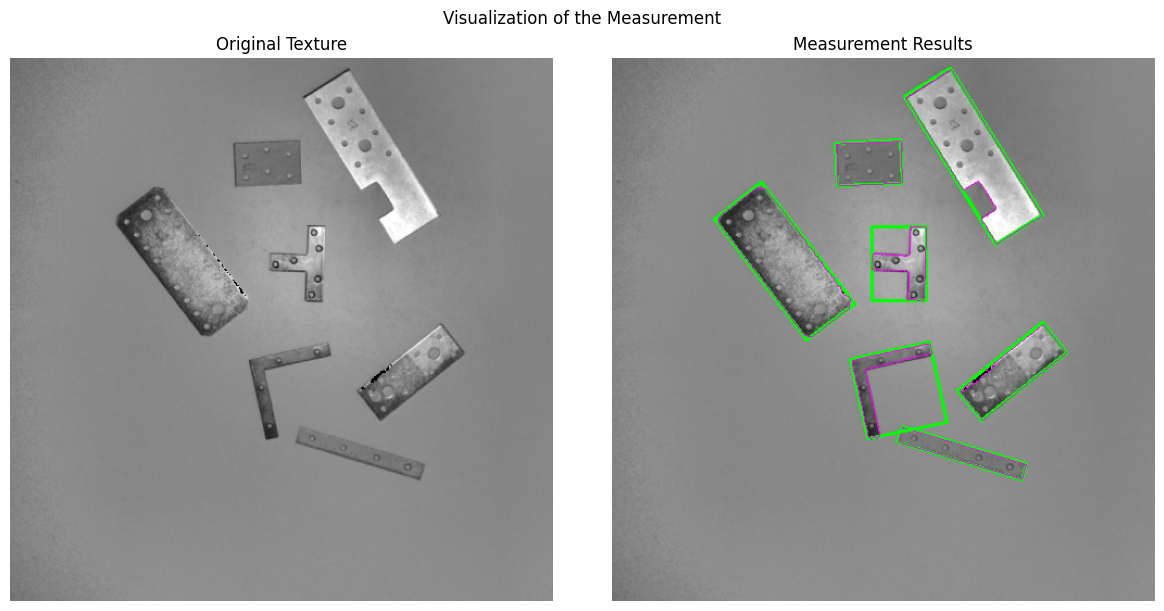

In [5]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6), constrained_layout = True)
fig.suptitle("Visualization of the Measurement")

# Plot original texture
im1 = ax1.imshow(texture)
ax1.set_title("Original Texture")
ax1.axis("off")
ax1.set_aspect("equal")

# Highlight measurement results
im2 = ax2.imshow(projected_texture)
ax2.set_title("Measurement Results")
ax2.axis("off")
ax2.set_aspect("equal")

plt.show()